In [1]:
# import libraries
#%matplotlib notebook 
from matplotlib import pyplot as plt
import numpy as np
import fabio, loki, h5py, sys, os

sys.path.insert(0, '../02-scripts/')
# from RingData import *
from integrators import *
from utilities import *
from calibrators import *

sys.path.insert(0, '/Applications/anaconda3/lib/python3.9/site-packages/loki')
from RingData import * #RingFit, InterpSimple, DiffCorr

## Q calibration

In [2]:
# set directory for data
datadir = '/Users/maddalena/Nextcloud/01-SU/projects/21-github/XRD/03-data/'

The required files for the q-calibration are the background and the calibrator scattering patterns.

In [3]:
# calibrator and bg filenames
calibrator_fn = '01-Ag-behenate-296.sfrm'
bg_fn = '02-blank-296.sfrm'

# open 2d scattering pattern
im_bg = fabio.open(datadir+bg_fn)
bg_ar = np.array(im_bg.data, dtype=float)
    
# save 2d pattern w/ and w/o bg in arrays
ar_calib_bg, ar_calib = open_sfrm_file(datadir+calibrator_fn, bg_ar)


Plot calibrator, background, and calibrator with subtracted background 2d images

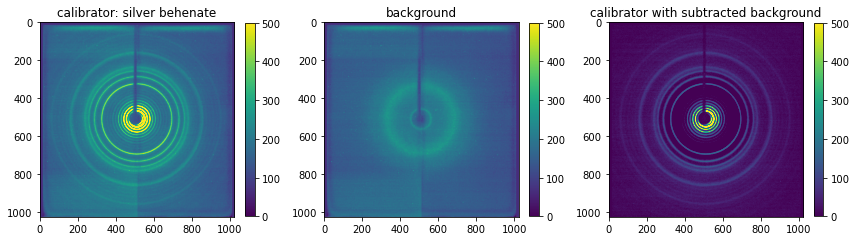

In [4]:
plt.figure(figsize=(12,5), tight_layout=True)
vmin, vmax = 0, 500

# -- plot calibrator with background
plt.subplot(1,3,1)
plt.imshow(ar_calib_bg, vmin=vmin, vmax=vmax)
plt.colorbar(fraction=0.045)
plt.title('calibrator: silver behenate')

# -- plot background
plt.subplot(1,3,2)
plt.imshow(im_bg.data, vmin=vmin, vmax=vmax)
plt.colorbar(fraction=0.045)
plt.title('background')

# -- plot calibrator without background
plt.subplot(1,3,3)
plt.imshow(ar_calib, vmin=vmin, vmax=vmax)
plt.colorbar(fraction=0.045)
plt.title('calibrator with subtracted background')

plt.show()

### Center guesses

In [5]:
# -- beam center
# after the first guess attempt, change ar_calib.shape[]/2. with the actual numbers to have better guesses
cx = 508.1  #ar_calib.shape[0]/2. 
cy = 509.5 #ar_calib.shape[1]/2.

# -- guess center
center_guess = [cx,cy] #intital guess for center
peak_radius_guess = 42
ring_param_guess = (center_guess[0], center_guess[1], peak_radius_guess)

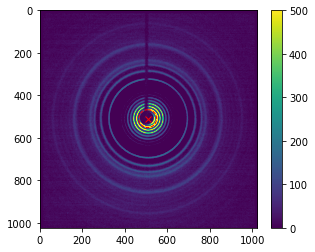

In [6]:
plt.figure(figsize=[5,4])
ax = plt.gca()

plt.imshow(ar_calib, vmax=vmax, vmin=vmin)
# initial guesses
plt.plot(center_guess[0], center_guess[1],'rx')
circ = plt.Circle(xy=(center_guess[0], center_guess[1]), radius=peak_radius_guess, lw=1, fc='none', ls='dashed' ,color='r')
# circ2 = plt.Circle(xy=(center_guess[0], center_guess[1]), radius=505, lw=1, fc='none', ls='dashed', color='r')
ax.add_patch(circ)
# ax.add_patch(circ2)

plt.colorbar()
plt.savefig('/Users/maddalena/Desktop/cal.png', dpi=300)
plt.show()

### Find center and first ring

In [7]:
# fit the first ring and find the center
RF = RingFit(ar_calib)

x_center, y_center, peak_radius = RF.fit_circle(beta_i=ring_param_guess) 
centers = np.array([x_center, y_center])

print(f'initial guesses: {ring_param_guess}')
print(f'final estimations: {x_center:.1f}, {y_center:.1f}, {peak_radius:.1f}')

# substitute the final estimations into the cx,cy two cells above

initial guesses: (508.1, 509.5, 42)
final estimations: 506.4, 508.8, 42.6


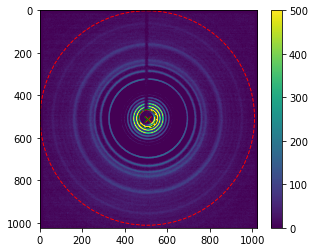

In [8]:
plt.figure(figsize=[5,4])
ax = plt.gca()

plt.imshow(ar_calib,vmax=vmax,vmin=vmin)
plt.plot(center_guess[0],center_guess[1],'rx')
plt.plot(x_center,y_center,'gx')

# with initial guesses
circ = plt.Circle(xy=(center_guess[0], center_guess[1]), radius=peak_radius_guess, lw=1, fc='none', ls='dashed' ,color='r')
circ2 = plt.Circle(xy=(x_center, x_center), radius=505, lw=1, fc='none', ls='dashed', color='r')
# with final xy:
circ3 = plt.Circle(xy=(x_center, y_center), radius=peak_radius, lw=1, fc='none', ls='dashed' ,color='g')

ax.add_patch(circ)
ax.add_patch(circ2)
ax.add_patch(circ3)

plt.colorbar()
plt.savefig('/Users/maddalena/Desktop/cal_fit.png', dpi=300)
plt.show()

### Parameters and mask

In [9]:
# reference values
q_ref = silver_behenate()

In [10]:
# -- angular integration parameters
n_bins = 500            # number of bins
min_x,max_x = 0, 500    # n_bins

# -- experimental parameters
p_size = 96e-6          # size of the pixels
d = 50e-3               # detector distance
Cu_energy = 8041.5      # energy of the beam (Cu K\alpha)

In [11]:
# -- mask parameters
int_r, ext_r = 33, 700   # internal and external radii for masking
slope, offset, thick = 1e-5, 0, 10 # beam stop stick

mask = beam_blocker_mask(nx=1024,ny=1024,center_x=int(y_center),center_y=int(x_center),
                         radius=int_r,radius2=ext_r,
                         slope=slope,offset=offset,thickness=thick)


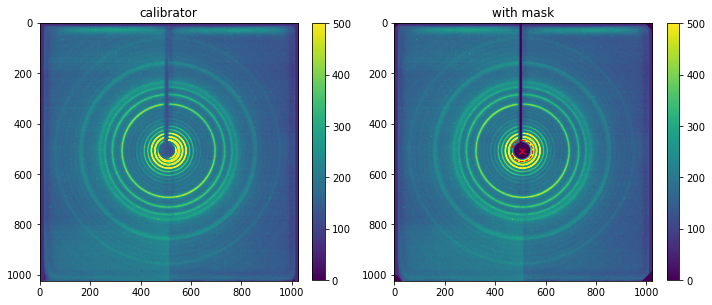

In [12]:
# Silver behenate
plt.figure(figsize=(10,5), tight_layout=True)
vmin,vmax = 0, 500

# -- plot calibrator with background
plt.subplot(1,2,1)
plt.imshow(ar_calib_bg, vmin=vmin, vmax=vmax)
plt.colorbar(fraction=0.045)
plt.title('calibrator')

# -- plot background
plt.subplot(1,2,2)
ax = plt.gca()
plt.imshow(ar_calib_bg*mask, vmin=vmin, vmax=vmax)
plt.plot(center_guess[0],center_guess[1],'rx')
circ = plt.Circle(xy=(x_center, y_center), radius=peak_radius_guess, lw=1, fc='none', ls='dashed' ,color='r')
ax.add_patch(circ)
plt.colorbar(fraction=0.045)
plt.title('with mask')

plt.show()

### Angular integration

In [13]:
# r-map
rad_dist = radial_distances(ar_calib, center=(int(y_center),int(x_center)))

# method 1
r, iq = angular_average(ar_calib, mask=mask, rad=rad_dist, threshold=0, nx=n_bins)
q = q_scale(r, detector_distance=d, photon_energy=Cu_energy, pixel_size=p_size)

# method 2
ra = RadialAverager(rad_dist, mask=mask, n_bins=500)#n_bins)
iq2 = ra(np.array(ar_calib))
r2  = ra.bin_centers
q2 = q_scale(r2, detector_distance=d, photon_energy=Cu_energy, pixel_size=p_size)

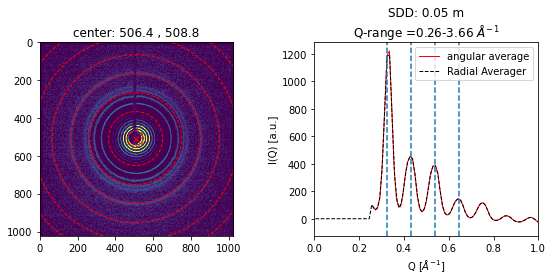

In [14]:
plt.figure(figsize=[8,4])

plt.subplot(1,2,1)
ax = plt.gca()
plt.plot(x_center,y_center,'rx')
for i in range(10):
    circ = plt.Circle(xy=(x_center, y_center), radius=peak_radius+i*100, lw=1., fc='none', ls='dashed' ,color='r')
    ax.add_patch(circ)
ax.imshow(ar_calib, interpolation='nearest',clim=[0,10], vmax=vmax, vmin=vmin)
plt.title('center: %.1f , %.1f'%(x_center,y_center))


plt.subplot(1,2,2)
plt.plot(q, iq, lw =1, c='r', label='angular average', alpha=1)
plt.plot(q2, iq2, ls='--', lw =1, c='k', label='Radial Averager', alpha=1)
for i in range(2,6):
    plt.axvline(x = q_ref[i],ls ='--')
    
plt.xlabel('Q [$\AA^{-1}$]')
plt.ylabel('I(Q) [a.u.]')
plt.xlim(0.,1.)
plt.legend()
plt.title(f'SDD: {d:.2f} m\nQ-range ={q[0]:.2f}-{q[-1]:.2f} $\AA^{{-1}}$')

plt.tight_layout()
plt.show()

## Save calibration

In [15]:
# True if you want to save the mask, centers and Iq,q of calibrator in h5 file (last two cells)
save = False

In [16]:
if save == True:
    if not os.path.exists('../04-processed'):
        os.makedirs('../04-processed')
        
    np.save('../04-processed/q', q)
    np.save('../04-processed/mask', mask)
    np.save('../04-processed/centers', centers)

## Not necessary

In [17]:
date_today = '2023-02-22'

if save == True:
    f = h5py.File(f'../04-processed/calibrator-{date_today}.hdf5', 'w') # w stads for write
    g1 = f.create_group('Iq')
    g1.create_dataset('q0114', data=q)
    g1.create_dataset('Iq', data=iq)
    g1.create_dataset('Iq2', data=iq2)
    g1.create_dataset('q2', data=q2)
    
    g2 = f.create_group('2d-pattern')
    g2.create_dataset('no_bg', data=ar_calib)
    g2.create_dataset('with_bg', data=ar_calib_bg)
    g2.create_dataset('bg', data=im_bg.data)
    g2.create_dataset('mask', data=mask)
    
    g3 = f.create_group('info')
    g3.create_dataset('energy', data=Cu_energy)
    g3.create_dataset('pixel_size', data=p_size)
    g3.create_dataset('detector-sample', data=d)
    g3.create_dataset('xy-center', data=(x_center, y_center))
    g3.create_dataset('peak-radius', data=peak_radius)
    
    f.visititems(visit_func)   
    f.close()